In [1]:
%reload_ext autoreload
%autoreload 2

import os, psutil

os.environ['NUMEXPR_MAX_THREADS'] = '20'
from alphadia.extraction import processlogger
processlogger.init_logging()
import logging

logger = logging.getLogger()

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import neptune.new as neptune

#from alphabase.spectral_library.flat import SpecLibFlat
from alphabase.spectral_library.base import SpecLibBase
#from alphabase.spectral_library.reader import LibraryReaderBase

from alphadia.extraction.data import TimsTOFDIA
from alphadia.extraction.planning import Plan, Workflow
from alphadia.extraction.calibration import RunCalibration
from alphadia.extraction.candidateselection import MS1CentricCandidateSelection
from alphadia.extraction.scoring import fdr_correction, MS2ExtractionWorkflow
import alphadia.extraction.utils as utils
yaml_file = 'config.yaml'

raw_files = ['/Users/georgwallmann/Documents/data/alphadia_benchmarking/raw_data/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_diaPASEF_S4-A1_1_500.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_diaPASEF_S4-A2_1_504.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_diaPASEF_S4-A3_1_508.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_diaPASEF_S4-A4_1_512.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A1_1_449.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A2_1_453.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A3_1_457.d',
             #'/Users/georgwallmann/Documents/data/raw_data/Alpha_dia_benchmarking/diaPASEF_vs_synchroPASEF/20221221_TIMS05_PaSk_SA_HeLa_Evo05_200ng_21min_IM0713_SyP_classical_5bins_S2-A4_1_464.d'

             ]

output_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/alphadia_runs/2023_02_27_diaPASEF_vs_synchroPASEF_hybrid/hela_48_fractions'

try:
    neptune_token = os.environ['NEPTUNE_TOKEN']
except KeyError:
    logger.error('NEPTUNE_TOKEN environtment variable not set')


0:00:02.374183  WARNING: WARNING: Temp mmap arrays are written to /var/folders/lc/9594t94d5b5_gn0y04w1jh980000gn/T/temp_mmap_0p4vpadq. Cleanup of this folder is OS dependant, and might need to be triggered manually! Current space: 1,193,803,227,136
0:00:02.374876  WARNING: WARNING: No Bruker libraries are available for this operating system. Mobility and m/z values need to be estimated. While this estimation often returns acceptable results with errors < 0.02 Th, huge errors (e.g. offsets of 6 Th) have already been observed for some samples!
0:00:02.375056  INFO: 
0:00:04.146431  ERROR: NEPTUNE_TOKEN environtment variable not set


In [2]:
test_lib = SpecLibBase()
test_lib_location = '/Users/georgwallmann/Documents/data/alphadia_benchmarking/libraries/patricia_hela/21min_Evosep_HeLa_BR14_48fractions_diaPASEF_py_diAID_2_predicted_after_merge.hdf'
test_lib.load_hdf(test_lib_location, load_mod_seq=True)


In [3]:
test_lib.precursor_df['elution_group_idx'] = np.arange(len(test_lib.precursor_df))

In [4]:
plan = Plan(raw_files)
plan.from_spec_lib_base(test_lib)
#plan.run(output_location, keep_decoys=True, fdr=1.0)
for dia_data, precursors_flat, fragments_flat in plan.get_run_data():
    pass

0:00:06.996473  PROGRESS:       _   _      _         ___ ___   _   
0:00:06.996882  PROGRESS:      /_\ | |_ __| |_  __ _|   \_ _| /_\  
0:00:06.997133  PROGRESS:     / _ \| | '_ \ ' \/ _` | |) | | / _ \ 
0:00:06.997409  PROGRESS:    /_/ \_\_| .__/_||_\__,_|___/___/_/ \_\
0:00:06.997642  PROGRESS:            |_|                            
0:00:06.997819  PROGRESS: 
0:00:06.998139  INFO: loading default config from /Users/georgwallmann/Documents/git/alphadia/alphadia/extraction/../../misc/config/default.yaml
0:00:07.003304  PROGRESS: version: 1.0.1
0:00:07.003771  PROGRESS: hostname: Georgs-MacBook-Pro.local
0:00:07.004100  PROGRESS: date: 2023-03-07 14:46:34
0:00:12.843158  INFO: renaming precursor_columns columns
0:00:12.844056  INFO: renaming fragment_columns columns
0:00:12.844507  INFO: ========= Library Stats =========
0:00:12.844760  INFO: Number of precursors: 464,663
0:00:12.911463  INFO: 	thereof targets:234,993
0:00:12.911862  INFO: 	thereof decoys: 229,670
0:00:12.916045  IN

In [308]:
from alphadia.extraction import hybridselection

selection = hybridselection.HybridCandidateSelection(
    dia_data,
    precursors_flat[:10000],
    fragments_flat,
    rt_tolerance=360,
    mz_tolerance=30,
    mobility_tolerance=0.06,
    candidate_count=3,
    thread_count=20,
    #debug=True,
)

candidates, egs = selection()

3:22:10.102452  INFO: Duty cycle consists of 13 frames, 1.39 seconds cycle time
3:22:10.102924  INFO: Duty cycle consists of 928 scans, 0.00065 1/K_0 resolution
3:22:10.103242  INFO: Expected peak length in RT is 8.00 seconds, sigma is 1.44
3:22:10.103658  INFO: Expected peak length in mobility is 0.02 1/K_0, sigma is 7.73
 72%|███████▏  | 7210/10000 [00:56<00:21, 128.01it/s]


KeyboardInterrupt: 

In [214]:
@alphatims.utils.njit
def ceil_to_base_two(x):
    # borrowed from Bit Twiddling Hacks
    # https://graphics.stanford.edu/~seander/bithacks.html#RoundUpPowerOf2
    x -= 1
    x |= x >> 1
    x |= x >> 2
    x |= x >> 4
    x |= x >> 8
    x |= x >> 16

    x +=1
    return x

@alphatims.utils.njit
def roll(a, delta0, delta1):

    b = np.zeros_like(a)
    b[delta0:, delta1:] = a[:-delta0, :-delta1]
    b[:delta0, delta1:] = a[-delta0:, :-delta1]
    b[delta0:, :delta1] = a[:-delta0, -delta1:]
    b[:delta0, :delta1] = a[-delta0:, -delta1:]

    return b

@alphatims.utils.njit
def fourier_a0(dense, kernel):
    """
    Numba helper function to apply a gaussian filter to a dense stack.

    Parameters
    ----------

    dense : np.ndarray
        Array of shape (n_tofs, n_scans, n_frames)

    kernel : np.ndarray
        Array of shape (n_scans, n_frames)

    Returns
    -------

    np.ndarray
        Array of shape (n_tofs, n_scans, n_frames) containing the filtered dense stack.

    """

    k0, k1 = kernel.shape

    out = np.zeros_like(dense)

    fourier_filter = np.fft.rfft2(kernel, dense.shape[1:])
    for i in range(dense.shape[0]):
        out[i] = roll(np.fft.irfft2(np.fft.rfft2(dense[i]) * fourier_filter), -k0//2, -k1//2)

    return out

@alphatims.utils.njit
def fourier_a1(dense, kernel):
    """
    Numba helper function to apply a gaussian filter to a dense stack.

    Parameters
    ----------

    dense : np.ndarray
        Array of shape (n_tofs, n_observations, n_scans, n_frames)

    kernel : np.ndarray
        Array of shape (n_scans, n_frames)

    Returns
    -------

    np.ndarray
        Array of shape (n_tofs, n_observations, n_scans, n_frames) containing the filtered dense stack.

    """

    k0, k1 = kernel.shape

    out = np.zeros_like(dense)

    fourier_filter = np.fft.rfft2(kernel, dense.shape[2:])
    for i in range(dense.shape[0]):
        for j in range(dense.shape[1]):
            out[i, j] = roll(np.fft.irfft2(np.fft.rfft2(dense[i, j]) * fourier_filter), -k0//2, -k1//2)

    return out


import alphatims.utils
@alphatims.utils.njit
def fourier_filter(
        dense_stack, 
        kernel
    ):
    """Numba helper function to apply a gaussian filter to a dense stack. 
    The filter is applied as convolution wrapping around the edges, calculated in fourier space.

    As there seems to be no easy option to perform 2d fourier transforms in numba, the numpy fft is used in object mode.
    During multithreading the GIL has to be acquired to use the numpy fft and is realeased afterwards.

    Parameters
    ----------

    dense_stack : np.ndarray
        Array of shape (2, n_precursors, n_observations ,n_scans, n_cycles) containing the dense stack.

    kernel : np.ndarray
        Array of shape (k0, k1) containing the gaussian kernel.

    Returns
    -------
    smooth_output : np.ndarray
        Array of shape (n_precursors, n_observations, n_scans, n_cycles) containing the filtered dense stack.

    """

    k0 = kernel.shape[0]
    k1 = kernel.shape[1]

    # make sure both dimensions are even
    scan_mod = dense_stack.shape[3] % 2
    frame_mod = dense_stack.shape[4] % 2

    scan_size = dense_stack.shape[3] - scan_mod
    frame_size = dense_stack.shape[4] - frame_mod

    smooth_output = np.zeros((
        dense_stack.shape[1],
        dense_stack.shape[2], 
        scan_size,
        frame_size,
    ), dtype='float32')

    
    fourier_filter = np.fft.rfft2(kernel, smooth_output.shape[2:])

    for i in range(smooth_output.shape[0]):
        for j in range(smooth_output.shape[1]):
            layer = dense_stack[0,i,j,:scan_size,:frame_size]

            smooth_output[i,j] = roll(np.fft.irfft2(np.fft.rfft2(layer) * fourier_filter), -k0//2, -k1//2)
                

    return smooth_output

In [215]:
from alphadia.extraction import candidateselection

gaussian = candidateselection.GaussianFilter(dia_data)
kernel = gaussian.get_kernel()

2:40:34.020668  INFO: Duty cycle consists of 13 frames, 1.39 seconds cycle time
2:40:34.021273  INFO: Duty cycle consists of 928 scans, 0.00065 1/K_0 resolution
2:40:34.021713  INFO: Expected peak length in RT is 8.00 seconds, sigma is 1.44
2:40:34.022085  INFO: Expected peak length in mobility is 0.02 1/K_0, sigma is 7.73


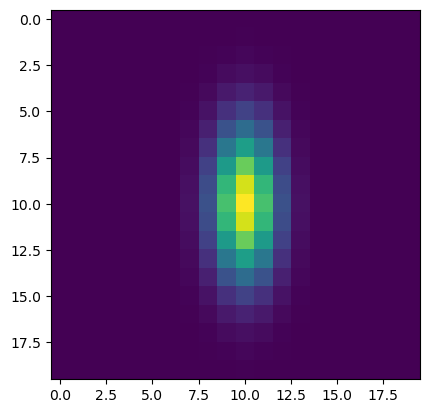

In [216]:
plt.imshow(kernel)

In [217]:
kernel[:,10:].shape

(20, 10)

In [218]:
p = dense_precursors[0,0,:,:32,:64]
p.shape

(1, 32, 64)

In [223]:
x = np.tile(p, (10,1,1,1))

In [224]:
x.shape

(10, 1, 32, 64)

In [225]:
%timeit smooth = fourier_a1(x, kernel)

149 µs ± 281 ns per loop (mean ± std. dev. of 7 runs, 10,000 loops each)


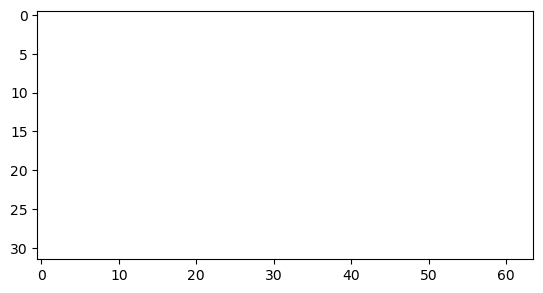

In [186]:
plt.imshow(p[0])

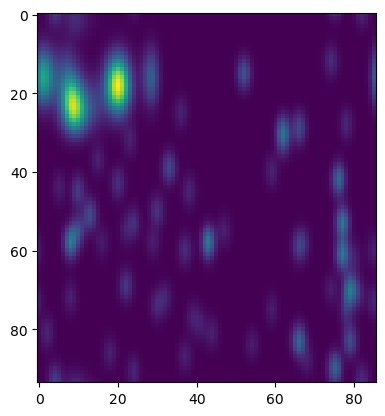

In [137]:
plt.imshow(smooth[0])

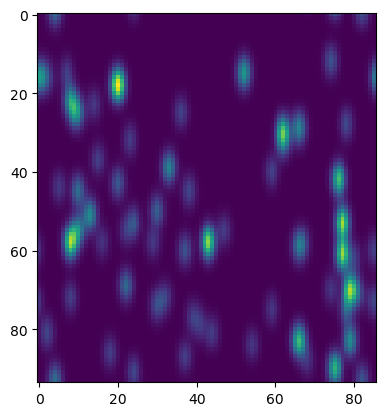

In [65]:
plt.imshow(roll(smooth[0,0],-10,-10))

In [6]:
import numba as nb
import numpy as np

@nb.njit
def jit_fft(x):
    return np.fft.fft(x)

a = np.array([2, 7, 1, 8, 2, 8, 1, 8])
jit_fft(a)

array([ 37.        -0.j        ,  -0.70710678+0.70710678j,
         2.        +1.j        ,   0.70710678+0.70710678j,
       -25.        -0.j        ,   0.70710678-0.70710678j,
         2.        -1.j        ,  -0.70710678-0.70710678j])

In [ ]:
from alphadia.extraction import quadrupole, scoring, features
q = quadrupole.SimpleQuadrupole(dia_data.cycle)

In [ ]:
from alphadia.extraction import scoring

extraction = scoring.MS2ExtractionWorkflow(
    dia_data,
    precursors_flat,
    fragments_flat,
    candidates,
    q,
    precursor_mz_tolerance=30,
    fragment_mz_tolerance=30
)

feature_df, fragment_df = extraction()

In [ ]:
df = scoring.fdr_correction(feature_df)

In [ ]:
df = scoring.fdr_correction(df)